# 1: Import các thư viện

In [ ]:
import pandas as pd # Đọc dữ liệu
import numpy as np # Xử lý dữ liệu
import matplotlib.pyplot as plt # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from keras.callbacks import EarlyStopping, ModelCheckpoint # Lưu lại mô hình huấn luyện tốt nhất
from tensorflow.keras.models import load_model # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential # Đầu vào
from keras.layers import LSTM # Học phụ thuộc
from keras.layers import Dropout # Tránh học tủ
from keras.layers import Dense # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Đo % sai số tuyệt đối trung bình

# 2: Đọc dữ liệu

In [ ]:
# Cấp quyền truy cập google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/dataset/FPT.csv')

# Drop dòng "Open Interest" không dùng đến trong dataset
df = df.drop(columns=["Open Interest"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

      Ticker         Date/Time   Open   High    Low  Close  Volume
0        FPT   12/25/2018 9:15  30.89  30.89  30.89  30.89   35410
1        FPT   12/25/2018 9:16  30.81  30.81  30.81  30.81     190
2        FPT   12/25/2018 9:17  30.74  30.81  30.74  30.74    1120
3        FPT   12/25/2018 9:18  30.74  30.74  30.74  30.74    2120
4        FPT   12/25/2018 9:19  30.74  30.74  30.74  30.74   22500
...      ...               ...    ...    ...    ...    ...     ...
97401    FPT  12/22/2020 14:24  58.20  58.20  58.20  58.20   27470
97402    FPT  12/22/2020 14:25  58.20  58.20  58.20  58.20   14820
97403    FPT  12/22/2020 14:26  58.20  58.20  58.20  58.20     500
97404    FPT  12/22/2020 14:29  58.10  58.10  58.10  58.10    2500
97405    FPT  12/22/2020 14:46  58.10  58.10  58.10  58.10   11170

[97406 rows x 7 columns]


# 3: Mô tả dữ liệu

In [ ]:
# Định dạng cấu trúc thời gian
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M")

In [ ]:
# Kích thước dữ liệu
df.shape

(97406, 7)

In [ ]:
# Dữ liệu 5 dòng đầu
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticker     97406 non-null  object        
 1   Date/Time  97406 non-null  datetime64[ns]
 2   Open       97406 non-null  float64       
 3   High       97406 non-null  float64       
 4   Low        97406 non-null  float64       
 5   Close      97406 non-null  float64       
 6   Volume     97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.2+ MB


In [ ]:
# Mô tả bộ dữ liệu
df.describe()

,Date/Time,Open,High,Low,Close,Volume
count,97406,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04
mean,2020-01-21 05:08:51.739112192,45.071630,45.090138,45.051430,45.071631,8.044173e+03
min,2018-12-25 09:15:00,30.250000,30.250000,30.220000,30.250000,1.000000e+01
25%,2019-08-06 11:06:15,39.740000,39.740000,39.700000,39.740000,7.500000e+02
50%,2020-01-31 10:37:30,46.950000,46.950000,46.950000,46.950000,2.960000e+03
75%,2020-07-14 09:54:45,49.200000,49.250000,49.170000,49.200000,8.960000e+03
max,2020-12-22 14:46:00,58.400000,58.500000,58.400000,58.400000,1.255930e+06
std,NaN,6.359803,6.364950,6.354245,6.359799,1.753203e+04


# 4: Tiền xử lý dữ liệu

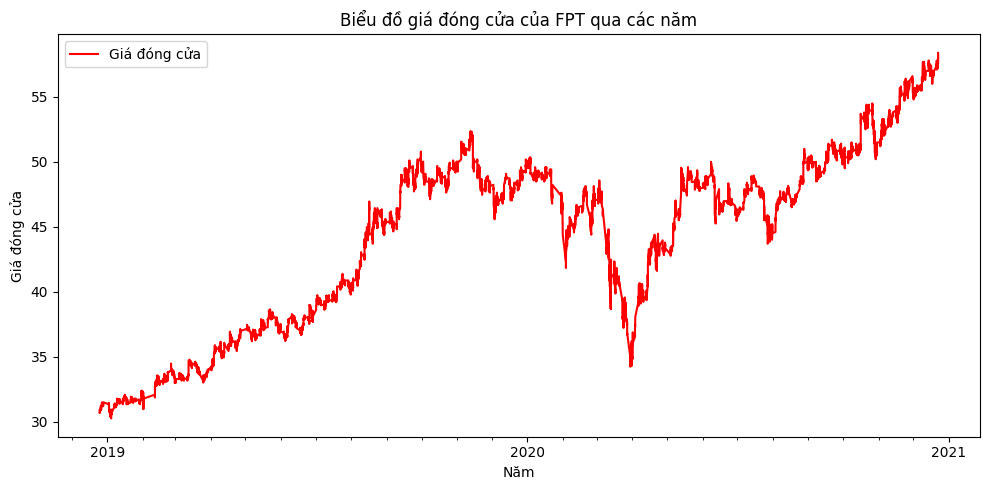

In [ ]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi
# Chuyển đổi cột "Date/Time" sang dạng datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Date/Time')

# Chuyển đổi định dạng các cột giá thành số thực
df['Close'] = df['Close'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

# Lấy thông tin năm từ cột "Date/Time"
df['Year'] = df['Date/Time'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Date/Time'], df['Close'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của FPT qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout() # Loại bỏ các giá trị trùng lặp
plt.show()

In [ ]:
df1 = pd.DataFrame(df,columns=['Date/Time','Close'])
df1.index = df1['Date/Time']
df1.drop('Date/Time', axis=1, inplace=True)
df1

,Close
Date/Time,
2018-12-25 09:15:00,30.89
2018-12-25 09:16:00,30.81
2018-12-25 09:17:00,30.74
2018-12-25 09:18:00,30.74
2018-12-25 09:19:00,30.74
...,...
2020-12-22 14:24:00,58.20
2020-12-22 14:25:00,58.20
2020-12-22 14:26:00,58.20


In [ ]:
# Chia tập dữ liệu: 80% để huấn luyện mô hình và 20% dùng để test
data = df1.values
num_rows = len(data)
train_size = int(0.8 * num_rows)

train_data = data[:train_size]
test_data = data[train_size:]

In [ ]:
data

array([[30.89],
       [30.81],
       [30.74],
       ...,
       [58.2 ],
       [58.1 ],
       [58.1 ]])

In [ ]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [ ]:
# Tạo vòng lặp các giá trị
x_train, y_train=[], []
for i in range(60, len(train_data)):
  x_train.append(sc_train[i-60:i, 0]) #lấy 60 giá đóng cửa liên tục
  y_train.append(sc_train[i, 0]) #lấy ra giá đóng cửa ngày hôm sau

In [ ]:
x_train

[array([0.02273535, 0.01989343, 0.01740675, 0.01740675, 0.01740675,
        0.01740675, 0.01456483, 0.03055062, 0.03339254, 0.03339254,
        0.03197158, 0.03055062, 0.03055062, 0.03055062, 0.03339254,
        0.03339254, 0.03055062, 0.03445826, 0.03445826, 0.02806394,
        0.02806394, 0.02522202, 0.02522202, 0.02522202, 0.02522202,
        0.02273535, 0.02273535, 0.02522202, 0.02273535, 0.02273535,
        0.02522202, 0.02522202, 0.02806394, 0.03339254, 0.03055062,
        0.03197158, 0.03197158, 0.03055062, 0.03055062, 0.03055062,
        0.03055062, 0.03339254, 0.03339254, 0.03339254, 0.03055062,
        0.03055062, 0.03055062, 0.03055062, 0.03055062, 0.03197158,
        0.03197158, 0.03055062, 0.03197158, 0.03055062, 0.03197158,
        0.03055062, 0.03055062, 0.03055062, 0.03055062, 0.03055062]),
 array([0.01989343, 0.01740675, 0.01740675, 0.01740675, 0.01740675,
        0.01456483, 0.03055062, 0.03339254, 0.03339254, 0.03197158,
        0.03055062, 0.03055062, 0.03055062, 0.

In [ ]:
y_train

[0.03197158081705154,
 0.03197158081705154,
 0.03197158081705154,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.029129662522202615,
 0.029129662522202615,
 0.029129662522202615,
 0.029129662522202615,
 0.029129662522202615,
 0.028063943161634075,
 0.029129662522202615,
 0.028063943161634075,
 0.029129662522202615,
 0.028063943161634075,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.028063943161634075,
 0.028063943161634075,
 0.026642984014209725,
 0.028063943161634075,
 0.028063943161634075,
 0.025222024866785153,
 0.025222024866785153,
 0.025222024866785153,
 0.024156305506216835,
 0.025222024866785153,
 0.025222024866785153,
 0.028063943161634075,
 0.028063943161634075,
 0.028063943161634075,
 0.028063943161634075,
 0.022735346358792263,
 0.022735346358792263,
 0.026642984014209725,
 0.026642984014209725,
 0.028063943161634075,
 0.026642984014209725,
 0.02806394316

In [ ]:
# Xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

# Xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# 5: Xây dựng và huấn luyện mô hình

## 5.1: Xây dựng

In [ ]:
# Xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào

# 2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
# Đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error', optimizer='adam')

## 5.2: Huấn luyện

In [ ]:
# Huấn luyện mô hình
save_model = "/content/drive/MyDrive/dataset/FPT_save_model.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='loss', patience=10) # Ngừng huấn luyện nếu như mô hình không còn cải thiện sau 10 epochs
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[best_model, early_stopping])

Epoch 1/100

Epoch 1: loss improved from inf to 0.03761, saving model to /content/drive/MyDrive/dataset/FPT_save_model.keras
1217/1217 - 197s - 162ms/step - loss: 0.0376
Epoch 2/100

Epoch 2: loss improved from 0.03761 to 0.02181, saving model to /content/drive/MyDrive/dataset/FPT_save_model.keras
1217/1217 - 201s - 165ms/step - loss: 0.0218
Epoch 3/100

Epoch 3: loss improved from 0.02181 to 0.01917, saving model to /content/drive/MyDrive/dataset/FPT_save_model.keras
1217/1217 - 200s - 164ms/step - loss: 0.0192
Epoch 4/100

Epoch 4: loss improved from 0.01917 to 0.01864, saving model to /content/drive/MyDrive/dataset/FPT_save_model.keras
1217/1217 - 201s - 165ms/step - loss: 0.0186
Epoch 5/100

Epoch 5: loss improved from 0.01864 to 0.01843, saving model to /content/drive/MyDrive/dataset/FPT_save_model.keras
1217/1217 - 206s - 170ms/step - loss: 0.0184
Epoch 6/100

Epoch 6: loss improved from 0.01843 to 0.01829, saving model to /content/drive/MyDrive/dataset/FPT_save_model.keras
1217/

In [ ]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/dataset/FPT_save_model.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

2434/2434 ━━━━━━━━━━━━━━━━━━━━ 120s 49ms/step


# 6: Sử dụng mô hình

In [ ]:
#xử lý dữ liệu test
test = df1[len(train_data)-60:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(60,test.shape[0]):
  x_test.append(sc_test[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[train_size:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

609/609 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step


# Độ chính xác của mô hình

<ipython-input-27-2aea35ffb013>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-27-2aea35ffb013>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


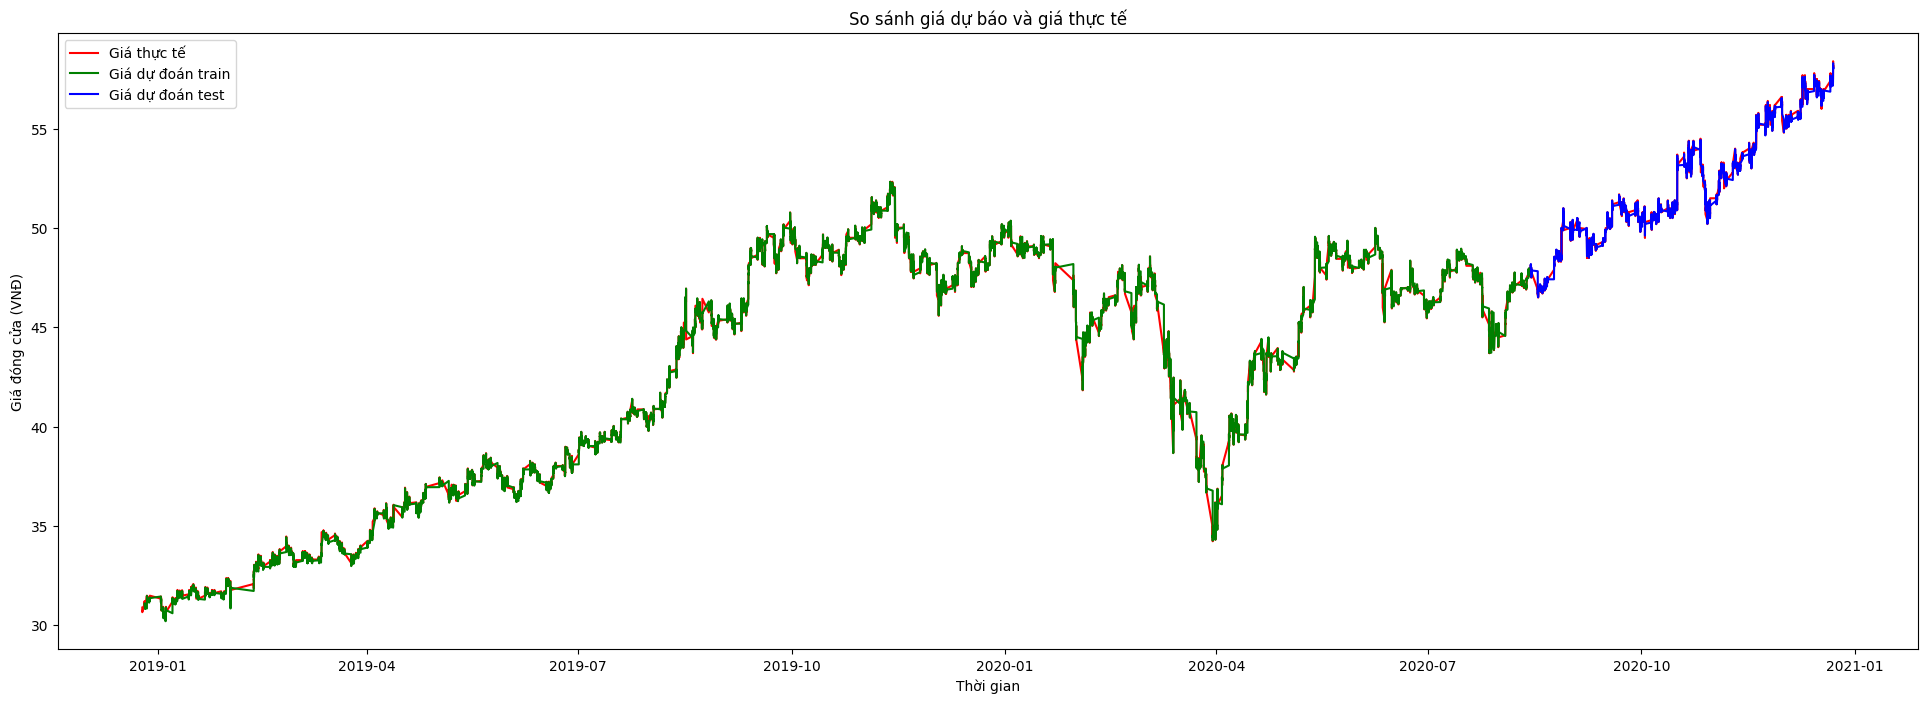

In [ ]:
#lập biểu đồ so sánh
train_data1 = df1[60:train_size]
test_data1 = df1[train_size:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train', color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test', color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [ ]:
#r2
print('Độ phù hợp tập train:', r2_score(y_train, y_train_predict))

#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:', mean_absolute_percentage_error(y_train, y_train_predict))

Độ phù hợp tập train: 0.9998713301973766
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.0417627563278636
Phần trăm sai số tuyệt đối trung bình tập train: 0.0009814857490513744


In [ ]:
train_data1

,Close,Dự đoán
Date/Time,,
2018-12-26 10:30:00,31.15,31.066156
2018-12-26 10:31:00,31.15,31.108486
2018-12-26 10:33:00,31.15,31.106941
2018-12-26 10:37:00,31.11,31.105965
2018-12-26 10:41:00,31.11,31.062357
...,...,...
2020-08-14 09:28:00,47.95,47.969528
2020-08-14 09:29:00,47.95,47.969940
2020-08-14 09:30:00,47.95,47.968586


In [ ]:
#r2
print('Độ phù hợp tập test:', r2_score(y_test, y_test_predict))

#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:', mean_absolute_percentage_error(y_test, y_test_predict))

Độ phù hợp tập test: 0.9993180488269932
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.053330416298049674
Phần trăm sai số tuyệt đối trung bình tập test: 0.0010077698868401817


In [ ]:
test_data1

,Close,Dự đoán
Date/Time,,
2020-08-14 09:33:00,48.10,48.018784
2020-08-14 09:34:00,48.10,48.096779
2020-08-14 09:35:00,48.10,48.120434
2020-08-14 09:36:00,48.10,48.120613
2020-08-14 09:37:00,48.15,48.117744
...,...,...
2020-12-22 14:24:00,58.20,58.072742
2020-12-22 14:25:00,58.20,58.104256
2020-12-22 14:26:00,58.20,58.111248


# Dự đoán biến động giá cổ phiếu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


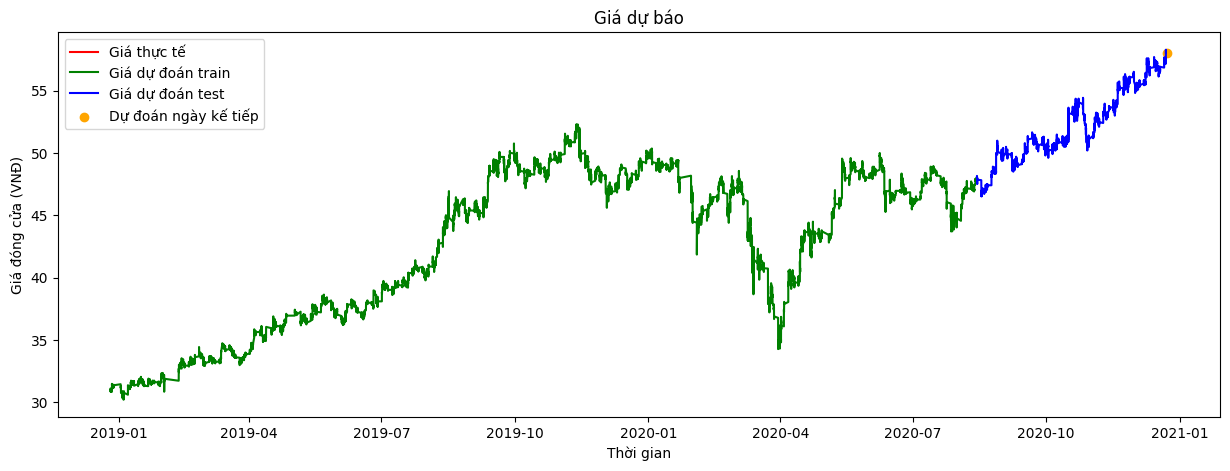

In [ ]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Date/Time'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Close'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Date/Time': [next_date], 'Close': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Date/Time'], df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('Giá dự báo')
plt.legend()
plt.show()

In [ ]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Close'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

# Biến động giá cổ phiếu = Giá cổ phiếu N phút sau - Giá cổ phiếu hiện tại
stock_price_fluctuations = y_next_predict[0][0] - actual_closing_price
print("Biến động giá cổ phiếu:", stock_price_fluctuations)

                 Ngày  Giá dự đoán  Giá ngày trước
0 2020-12-23 14:46:00    58.014294            58.1
Biến động giá cổ phiếu: -0.08570632934570455
